# Análisis de Telemetría de Sesiones
**Autor:** Grupo 05  
**Fecha:** 2025-03-27  

**Objetivo:**  
Comprobar que el uso de las armas se adecúa al objetivo para el que fueron diseñadas.

**Preguntas de investigación:**  
1. ¿Se usan las armas a las distancias para las que fueron diseñadas?  
2. ¿Se adecúa el uso al diseño de los niveles 2 y 3?  
3. ¿La dispersión de la escopeta es intuitiva y adecuada?

## 1. Introducción

**Objetivo:**  
Comprobar que el uso de las armas se adecúa al objetivo para el que fueron diseñadas.

**Preguntas de investigación:**  
1. ¿Se usan las armas a las distancias para las que fueron diseñadas?  
2. ¿Se adecúa el uso al diseño de los niveles 2 y 3?  
3. ¿La dispersión de la escopeta es intuitiva y adecuada?

## 2. Imports y configuración inicial

In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')
DATA_DIR = 'data'


C:\Users\roiqd\AppData\Local\Temp\ipykernel_15804\2202143263.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 3. Carga y vista previa de los JSON

In [2]:
# Carga y vista previa de los JSON
import pandas as pd

# Listar archivos
paths = glob.glob(os.path.join(DATA_DIR, 'telemetry_*.json'))
print(f"{len(paths)} archivos JSON encontrados.")


# Cargar en DataFrame
df = pd.concat([pd.read_json(p) for p in paths], ignore_index=True)

# 6) Vistazo final
print(df.dtypes[['sessionID','timestamp']])
#df[['sessionID','timestamp']].head(5)



11 archivos JSON encontrados.
sessionID            object
timestamp    datetime64[ns]
dtype: object


## 4. Preprocesado de eventos
- Separar eventos de `Shot` y `ShotCollision`.
- Parsear la columna `otherWeaponsInfo` a diccionario.
- Unir cada disparo con su colisión mediante `sessionID + bulletID`.

In [3]:
# Preprocesado de eventos

import json, ast

# Extraer Shot y ShotCollision
shots = df[df.eventType == 'Shot'].copy()
colls = df[df.eventType == 'ShotCollision'].copy()

print(f"Disparos (Shot): {len(shots)} filas")
print(f"Colisiones (ShotCollision): {len(colls)} filas\n")

# Parsear otherWeaponsInfo a dict (JSON o literal de Python)
def _parse_other(info):
    if isinstance(info, dict):
        return info
    if pd.isna(info) or info == '':
        return {}
    if isinstance(info, str):
        try:
            return json.loads(info)
        except:
            try:
                return ast.literal_eval(info)
            except:
                return {}
    return {}

shots['otherWeaponsInfo'] = shots['otherWeaponsInfo'].apply(_parse_other)

# Unir disparos con colisiones (sessionID + bulletID) usando suffixes
merged = pd.merge(
    shots,
    colls,
    on=['sessionID','bulletID'],
    how='left',
    suffixes=('','_coll')
)

# Vista previa
print("Columnas tras merge:", merged.columns.tolist(), "\n")
#merged.head()



Disparos (Shot): 1100 filas
Colisiones (ShotCollision): 1333 filas

Columnas tras merge: ['eventType', 'gameID', 'playerID', 'sessionID', 'timestamp', 'levelStarted', 'bulletID', 'otherWeaponsInfo', 'posX', 'posY', 'posZ', 'weaponUsed', 'hasHitEnemy', 'hasKillEnemy', 'eventType_coll', 'gameID_coll', 'playerID_coll', 'timestamp_coll', 'levelStarted_coll', 'otherWeaponsInfo_coll', 'posX_coll', 'posY_coll', 'posZ_coll', 'weaponUsed_coll', 'hasHitEnemy_coll', 'hasKillEnemy_coll'] 



## 5. Métricas de uso óptimo por distancia
- Calcular distancia entre `posX,posY,posZ` de disparo y colisión.
- Categorizar en “corta” (0–12 m), “media” (12–25 m) y “larga” (25–60 m).
- Filtrar solo disparos con munición en otras armas.
- Para pistola, escopeta y rifle, calcular % de impactos en cada rango.

Impactos brutos por arma y franja:


C:\Users\roiqd\AppData\Local\Temp\ipykernel_15804\972289765.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['weaponUsed','range_cat'])


range_cat,corta,media,larga
weaponUsed,,,
Pistola,144,260,307
Escopeta,7,41,44
Rifle,6,29,33


% de impactos por franja (normalizado por arma):


range_cat,corta,media,larga
weaponUsed,,,
Pistola,20.3,36.6,43.2
Escopeta,7.6,44.6,47.8
Rifle,8.8,42.6,48.5


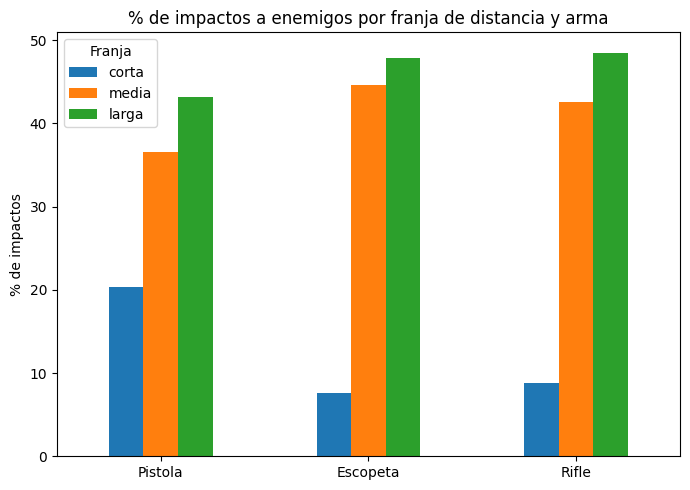

In [4]:
# 5. Métricas de uso óptimo por distancia (hits por franja / hits totales por arma)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Preservamos el orden original
df_ord = df.reset_index().rename(columns={'index':'orig_order'})




# Preparamos shot_df con orig_order
shot_df = df_ord[df_ord.eventType=='Shot'][[
    'orig_order','sessionID','bulletID','weaponUsed',
    'posX','posY','posZ','otherWeaponsInfo'
]].copy()

# Preparamos coll_df con timestamp y coordenadas, renombramos
coll_df = df_ord[df_ord.eventType=='ShotCollision'][[
    'sessionID','bulletID','timestamp','posX','posY','posZ','hasHitEnemy','hasKillEnemy'
]].rename(columns={
    'timestamp':'timestamp_coll',
    'posX':'posX_coll','posY':'posY_coll','posZ':'posZ_coll'
})

# Deduplciamos por primera colisión de cada bala
coll_df = (
    coll_df
    .sort_values(['sessionID','bulletID','timestamp_coll'])
    .drop_duplicates(['sessionID','bulletID'], keep='first')
)


# Merge 1:1 shot ↔ primera colisión
merged_shot = pd.merge(
    shot_df,
    coll_df,
    on=['sessionID','bulletID'],
    how='left'
)

# Partimos de merged_shot (debe traer posX, posY, posZ, posX_coll, posY_coll, posZ_coll, weaponUsed, hasHitEnemy)
df5 = merged_shot.copy()

# 1) Filtrar solo los impactos reales
hits = df5[df5['hasHitEnemy'] == 1].copy()

# 2) Calcular distancia 3D
hits['distance'] = np.sqrt(
    (hits['posX']     - hits['posX_coll'])**2 +
    (hits['posY']     - hits['posY_coll'])**2 +
    (hits['posZ']     - hits['posZ_coll'])**2
)

# 3) Categorizar en franjas
bins   = [0, 12, 25, 60]
labels = ['corta','media','larga']
hits['range_cat'] = pd.cut(hits['distance'], bins=bins, labels=labels, right=False)

# 4) Contar impactos por arma y franja (raw hits)
raw_hits = (
    hits
    .groupby(['weaponUsed','range_cat'])
    .size()
    .unstack(fill_value=0)
    .rename(index={0:'Pistola',1:'Escopeta',2:'Rifle'})
)
print("Impactos brutos por arma y franja:")
display(raw_hits)

# 5) Calcular %: cada franja ÷ total impactos de esa arma
pct_hits = raw_hits.div(raw_hits.sum(axis=1), axis=0) * 100
pct_hits = pct_hits.round(1)
print("% de impactos por franja (normalizado por arma):")
display(pct_hits)

# 6) Gráfico para visualizar la distribución
ax = pct_hits.plot.bar(
    figsize=(7,5),
    title='% de impactos a enemigos por franja de distancia y arma',
    ylabel='% de impactos'
)
ax.set_xlabel('')
plt.xticks(rotation=0)
plt.legend(title='Franja')
plt.tight_layout()
plt.show()



## 6. Uso de escopeta y rifle por nivel (2 y 3)
- Asignar a cada disparo el nivel usando orden de eventos y `ffill`.
- Filtrar nivel 2 y nivel 3.
- Comparar % de pistola vs escopeta en nivel 2.
- Comparar % de pistola, escopeta y rifle en nivel 3.

Disparos por nivel:
 level
1.0    276
2.0    352
3.0    472
Name: count, dtype: int64 



,Disparos,% Disparos
weaponUsed,,
Pistola,282,80.1
Escopeta,70,19.9


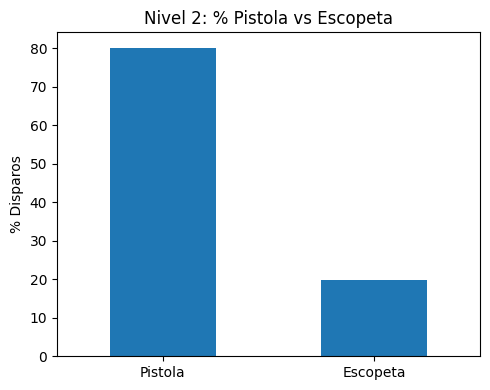

,Disparos,% Disparos
weaponUsed,,
Pistola,353,74.8
Escopeta,45,9.5
Rifle,74,15.7


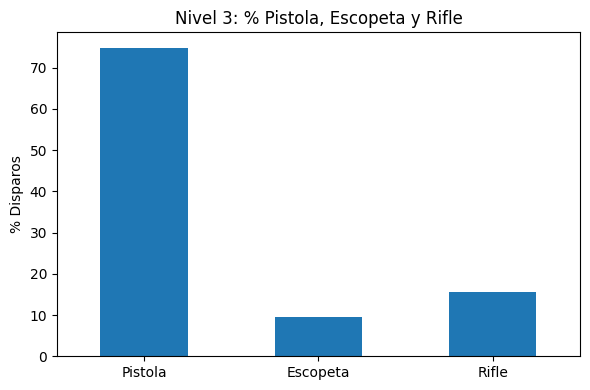

In [5]:
import pandas as pd
import numpy as np

# Uso de escopeta y rifle por nivel (2 y 3) — colisiones deduplicadas

# Asignar nivel usando ffill sobre orig_order
df_ev = df_ord[df_ord.eventType.isin(['LevelStart','Shot'])].copy()
df_ev['eventOrder'] = df_ev['eventType'].map({'LevelStart':0,'Shot':1})
df_ev = df_ev.sort_values(['sessionID','orig_order','eventOrder'])
df_ev['lvl_ff'] = df_ev['levelStarted'].where(df_ev.eventType=='LevelStart', pd.NA)
df_ev['lvl_ff'] = df_ev.groupby('sessionID')['lvl_ff'].ffill()

lvl_map = (
    df_ev[df_ev.eventType=='Shot'][['orig_order','lvl_ff']]
      .assign(level=lambda d: d['lvl_ff']+1)
)

# Unimos nivel a cada disparo 1:1
shots_lvl = pd.merge(
    merged_shot,
    lvl_map[['orig_order','level']],
    on='orig_order',
    how='inner'
)

# Verificamos recuentos (deberían sumar 719)
print("Disparos por nivel:\n", shots_lvl['level'].value_counts().sort_index(), "\n")

# Nivel 2: Pistola vs Escopeta
lvl2 = shots_lvl[shots_lvl['level']==2]
counts2 = lvl2['weaponUsed'].map({0:'Pistola',1:'Escopeta'})\
           .value_counts().reindex(['Pistola','Escopeta'],fill_value=0)
pct2    = (counts2/counts2.sum()*100).round(1)
tabla2  = pd.DataFrame({'Disparos':counts2,'% Disparos':pct2})
display(tabla2)

ax = tabla2['% Disparos'].plot.bar(
    figsize=(5,4),
    title='Nivel 2: % Pistola vs Escopeta'
)
ax.set_ylabel('% Disparos'); ax.set_xlabel('')
plt.xticks(rotation=0); plt.tight_layout(); plt.show()

# Nivel 3: Pistola, Escopeta y Rifle
lvl3 = shots_lvl[shots_lvl['level']==3]
counts3 = lvl3['weaponUsed'].map({0:'Pistola',1:'Escopeta',2:'Rifle'})\
           .value_counts().reindex(['Pistola','Escopeta','Rifle'],fill_value=0)
pct3    = (counts3/counts3.sum()*100).round(1)
tabla3  = pd.DataFrame({'Disparos':counts3,'% Disparos':pct3})
display(tabla3)

ax = tabla3['% Disparos'].plot.bar(
    figsize=(6,4),
    title='Nivel 3: % Pistola, Escopeta y Rifle'
)
ax.set_ylabel('% Disparos'); ax.set_xlabel('')
plt.xticks(rotation=0); plt.tight_layout(); plt.show()


## 7. Dispersión de la escopeta
- De los disparos a escopeta, contar perdigones que colisionan vs fallidos (`hasHitEnemy=False`).
- Calcular ratio “acertados/fallidos”.

### Dispersión de la escopeta ###


,Perdigones totales,Acertados,Fallidos,Ratio A/F
Escopeta,115,92,23,4.0


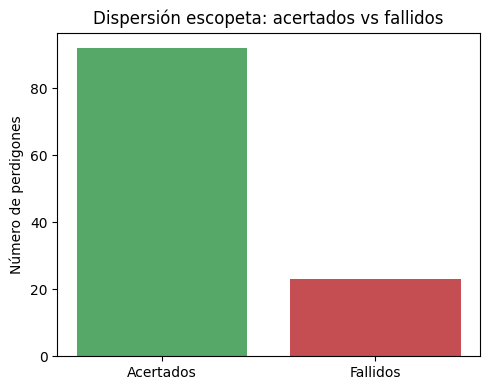

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#  Filtro merged_shot para quedarnos sólo con disparos de escopeta
esc = merged_shot[merged_shot['weaponUsed'] == 1].copy()

#  Conteos 
acertados = (esc['hasHitEnemy'] == 1).sum()   # True → 0
fallidos  = (esc['hasHitEnemy'] == 0).sum()   # False → 1

#  Total y ratio
total = acertados + fallidos
ratio = (acertados / fallidos).round(2) if fallidos > 0 else np.nan

#  Tabla resumen
tabla7 = pd.DataFrame({
    'Perdigones totales': [total],
    'Acertados':          [acertados],
    'Fallidos':           [fallidos],
    'Ratio A/F':          [ratio]
}, index=['Escopeta'])

print("### Dispersión de la escopeta ###")
display(tabla7)

#  Gráfico de barras
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(
    ['Acertados','Fallidos'],
    [acertados, fallidos],
    color=['#55A868','#C44E52']  # verde para aciertos, rojo para fallos
)
ax.set_title('Dispersión escopeta: acertados vs fallidos')
ax.set_ylabel('Número de perdigones')
plt.tight_layout()
plt.show()

